# EDA

In [79]:
# # MovieLens Data Exploration
# This notebook explores the ratings.csv file to understand the data distribution.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# -------------------------------------
from surprise import Reader, Dataset, KNNBasic, SVD,SVDpp,NMF
from surprise.model_selection import cross_validate

In [64]:
# Set a nice style for the plots
sns.set_style("whitegrid")

# %%
# 1. Load the Data
# ----------------
# Make sure 'ratings.csv' is in the same folder. 
# If it's in a subfolder, use 'data/ratings.csv'
file_path = 'ml-latest-small/ratings.csv' 

try:
    # MovieLens data usually has these columns: userId, movieId, rating, timestamp
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"Error: Could not find {file_path}. Please check the file name and path.")

# %%
# 2. Basic Inspection
# -------------------
print("First 5 rows of the data:")
print(df.head())

print("\nData Info (Column types and missing values):")
print(df.info())

print("\nSummary Statistics (Mean, Min, Max):")
print(df['rating'].describe())

Data loaded successfully!
First 5 rows of the data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Data Info (Column types and missing values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Summary Statistics (Mean, Min, Max):
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [65]:
# %%
# 3. Unique Counts (Sparsity check)
# ---------------------------------
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_ratings = len(df)
u_ratings = sorted(df['rating'].unique())

print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")
print(f"Total number of ratings:  {n_ratings}")
print(f"Rating numbers:  {u_ratings}")

# Calculate Sparsity: How empty is the matrix?
# If every user rated every movie, sparsity would be 0%.
# A high sparsity (e.g., 98%) is normal for recommender systems.
total_possible_ratings = n_users * n_movies
sparsity = 1 - (n_ratings / total_possible_ratings)
print(f"Data Sparsity: {sparsity:.2%}")

Number of unique users: 610
Number of unique movies: 9724
Total number of ratings:  100836
Rating numbers:  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Data Sparsity: 98.30%


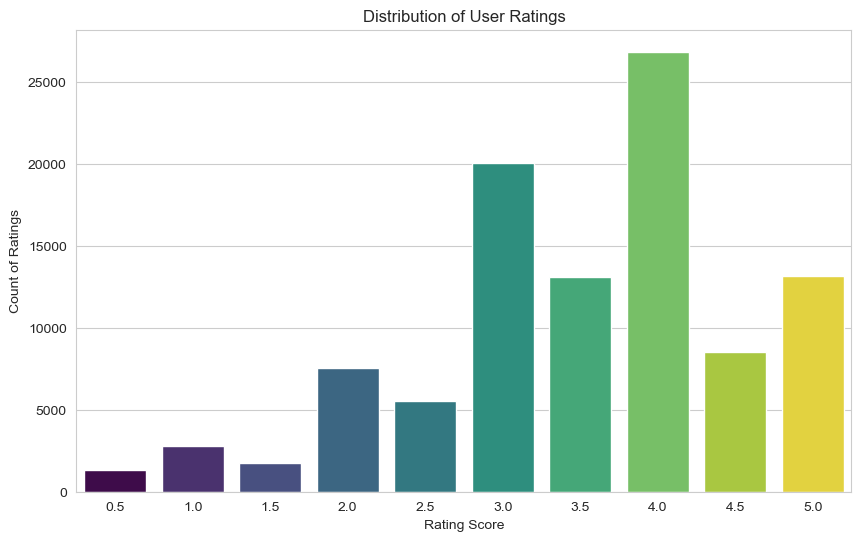

In [66]:
# 4. Distribution of Ratings
# --------------------------
# Are users generally positive (giving 4s and 5s) or negative?
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, hue='rating', palette='viridis', legend=False)
plt.title('Distribution of User Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Count of Ratings')
plt.show()

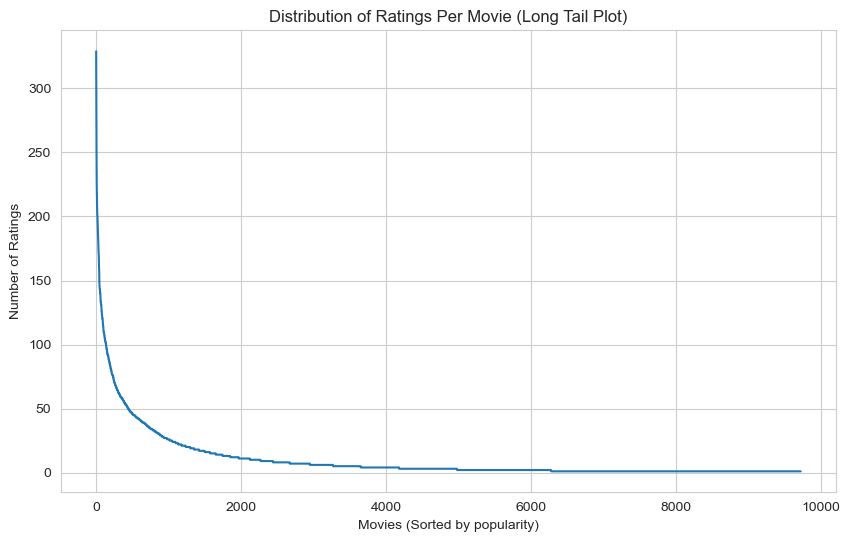


Top 5 Most Rated Movies (by ID):
         num_ratings  mean_rating
movieId                          
356              329     4.164134
318              317     4.429022
296              307     4.197068
593              279     4.161290
2571             278     4.192446


In [67]:
# 5. Ratings per Movie (Long Tail)
# --------------------------------
# Some movies have thousands of ratings, most have very few.
ratings_per_movie = df.groupby('movieId')['rating'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(ratings_per_movie.values)
plt.title('Distribution of Ratings Per Movie (Long Tail Plot)')
plt.xlabel('Movies (Sorted by popularity)')
plt.ylabel('Number of Ratings')
plt.show()

print("\nTop 5 Most Rated Movies (by ID):")
#print(ratings_per_movie.head())
# Get top 20 items by number of ratings
top_movies = ratings_per_movie.sort_values(ascending=False).head()
top_ids = top_movies.index.tolist()

# Compute mean rating for these top 20 items
mean_ratings = df[df['movieId'].isin(top_ids)].groupby('movieId')['rating'].mean()

# Combine count and mean into one DataFrame
top_summary = pd.DataFrame({
    'num_ratings': top_movies,
    'mean_rating': mean_ratings
}).sort_values('num_ratings', ascending=False)

print(top_summary)


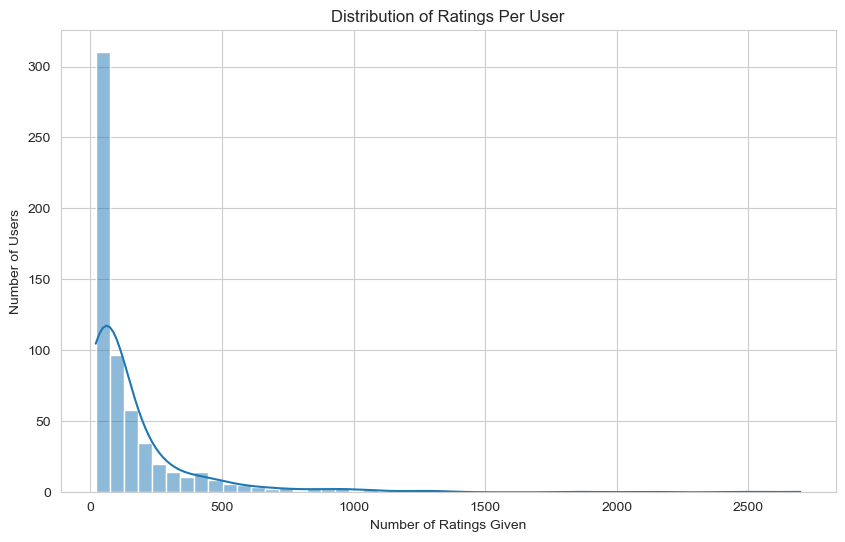


Average ratings per user: 165.30
Number of users with fewer than 30 ratings: 109
userId
442    20
406    20
147    20
194    20
569    20
576    20
431    20
207    20
278    20
320    20
Name: rating, dtype: int64


In [68]:
# 6. Ratings per User
# -------------------
# How active are the users?
ratings_per_user = df.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
plt.title('Distribution of Ratings Per User')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Number of Users')
plt.show()

print(f"\nAverage ratings per user: {ratings_per_user.mean():.2f}")

# Detect users with too few ratings
threshold = 30  # e.g., fewer than 5 ratings
few_ratings_users = ratings_per_user[ratings_per_user < threshold]

print(f"Number of users with fewer than {threshold} ratings: {few_ratings_users.shape[0]}")
# Sort ascending
ratings_per_user_sorted = ratings_per_user.sort_values(ascending=True)

# Show the first few (users with fewest ratings)
print(ratings_per_user_sorted.head(10))


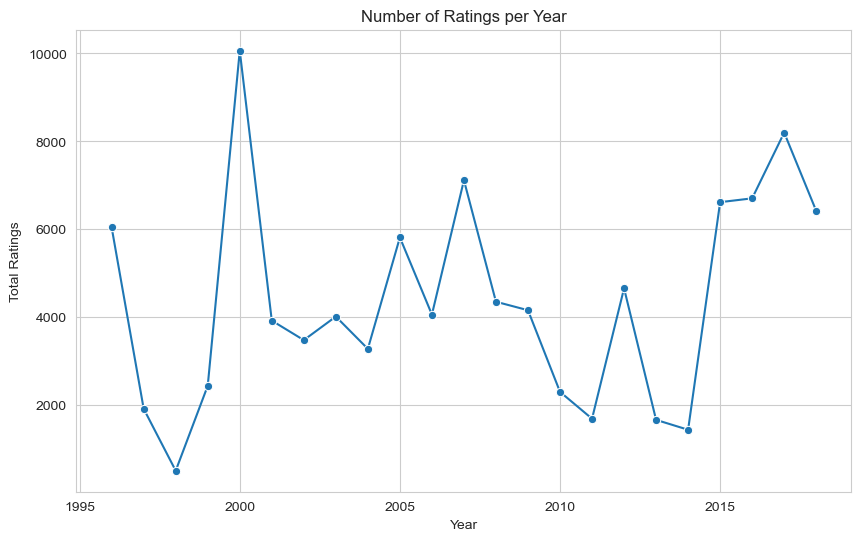

In [69]:
# %%
# 7. Ratings Over Time
# --------------------
# Convert the 'timestamp' column (seconds since 1970) to a datetime object
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the date
df['year'] = df['date'].dt.year

# Group by year to see the trend
ratings_per_year = df.groupby('year')['rating'].count()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values, marker='o')
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

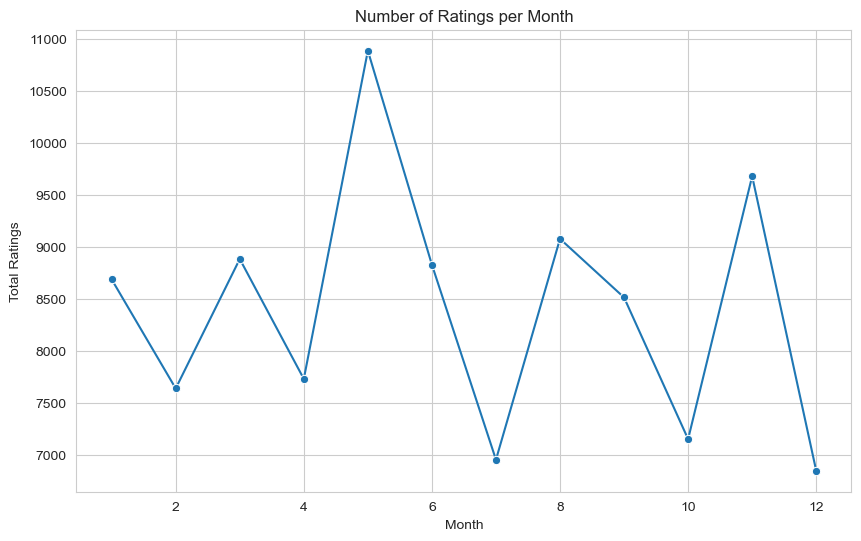

In [70]:
# %%
# 8. Ratings Over Time
# --------------------
# Convert the 'timestamp' column (seconds since 1970) to a datetime object
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the month from the date
df['month'] = df['date'].dt.month

# Group by month to see the trend
ratings_per_month = df.groupby('month')['rating'].count()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ratings_per_month.index, y=ratings_per_month.values, marker='o')
plt.title('Number of Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Total Ratings')
plt.grid(True)
plt.show()

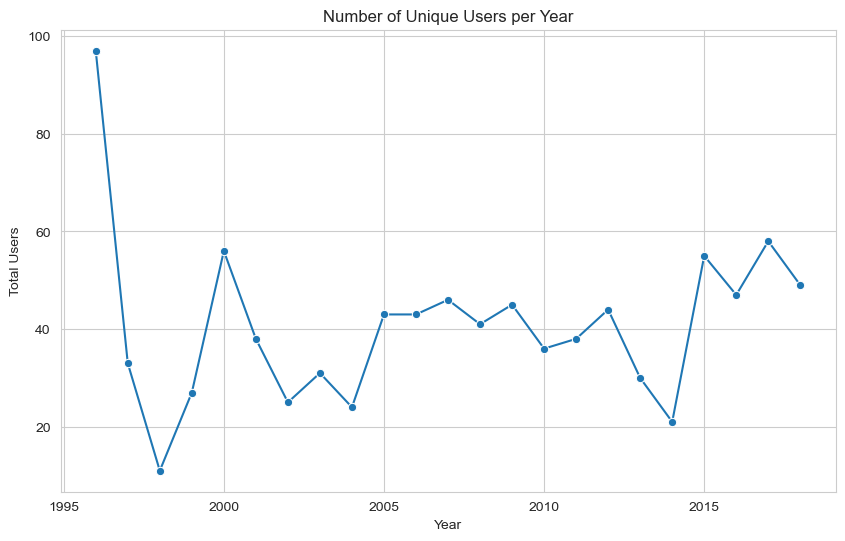

In [71]:
# %%
# 9. Unique Users per Year
# --------------------
# Group by year to see the trend
users_per_year = df.groupby('year')['userId'].nunique()

plt.figure(figsize=(10, 6))
sns.lineplot(x=users_per_year.index, y=users_per_year.values, marker='o')
plt.title('Number of Unique Users per Year')
plt.xlabel('Year')
plt.ylabel('Total Users')
plt.grid(True)
plt.show()

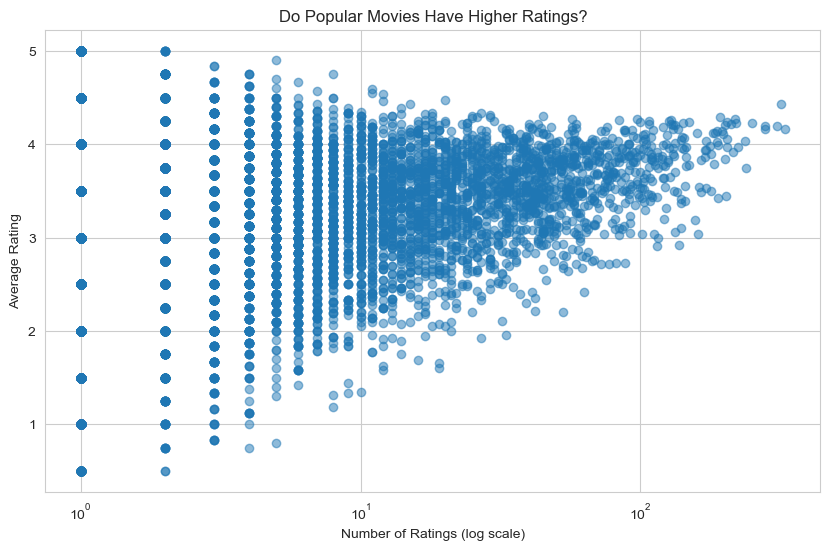

Correlation between number of ratings and average rating: 0.127


In [72]:
# %%
# 10.Do Popular Movies Have Higher Ratings?
# --------------------
# Compute number of ratings and mean rating per item
movie_stats = df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
movie_stats.rename(columns={'count':'num_ratings', 'mean':'mean_rating'}, inplace=True)

#print(movie_stats.head())
plt.figure(figsize=(10,6))
plt.scatter(movie_stats['num_ratings'], movie_stats['mean_rating'], alpha=0.5)
plt.xscale('log')  # Log scale for number of ratings
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.title("Do Popular Movies Have Higher Ratings?")
plt.show()
corr = movie_stats['num_ratings'].corr(movie_stats['mean_rating'])
print(f"Correlation between number of ratings and average rating: {corr:.3f}")


In [73]:
#preparing the dataset for surprise use
data_df = df[['userId', 'movieId', 'rating']]

# Define the rating scale (MovieLens ratings range from 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataframe into the Surprise Dataset format
surprise_data = Dataset.load_from_df(data_df, reader)

In [74]:
# User-Based Collaborative Filtering
sim_user_based_options = {
    "name": "cosine",
    "user_based": True,  # compute  similarities between users
}
algo = KNNBasic(sim_options=sim_user_based_options)
# Evaluate the algorithm using cross-validation
cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_mse': array([0.94536592, 0.94018825, 0.94792858, 0.95252488, 0.94192468]),
 'test_mae': array([0.74968399, 0.74738153, 0.74946588, 0.75243188, 0.74630135]),
 'fit_time': (0.027462005615234375,
  0.03137087821960449,
  0.03159666061401367,
  0.0316469669342041,
  0.030855894088745117),
 'test_time': (0.5671780109405518,
  0.5839779376983643,
  0.6357381343841553,
  0.5872371196746826,
  0.5912492275238037)}

In [75]:
## User-Based Collaborative Filtering with a specific k
k_values=[3,5,10]
result=[]

print(f"Running User-Based KNN with Cosine similarity for k={k_values}...")

for k in k_values:
   print(f"\n--- Training KNN with k={k} ---")
   # Initialize KNN with the specific k
   knn_item = KNNBasic(k=k, sim_options=sim_user_based_options, verbose=False)
    
   # Run 5-fold cross-validation
   cv_results = cross_validate(knn_item, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
   # Calculate average metrics
   avg_mse = cv_results['test_mse'].mean()
   avg_mae = cv_results['test_mae'].mean()
    
   # Store results
   result.append({'Memory Based':'User Based', 'k': k, 'MSE': avg_mse, 'MAE': avg_mae})
   print(f"k={k}: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}")

Running User-Based KNN with Cosine similarity for k=[3, 5, 10]...

--- Training KNN with k=3 ---
k=3: MSE=1.1225, MAE=0.8156

--- Training KNN with k=5 ---
k=5: MSE=1.0352, MAE=0.7825

--- Training KNN with k=10 ---
k=10: MSE=0.9734, MAE=0.7566


In [76]:
# Item-Based Collaborative Filtering
sim_item_based_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}
algo = KNNBasic(sim_options=sim_item_based_options)
# Evaluate the algorithm using cross-validation
cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'test_mse': array([0.94293543, 0.97215864, 0.95368756, 0.93255041, 0.96663746]),
 'test_mae': array([0.75559571, 0.76715421, 0.76074432, 0.75420634, 0.76543801]),
 'fit_time': (0.9594240188598633,
  0.9604771137237549,
  0.9506568908691406,
  0.9382998943328857,
  0.9608609676361084),
 'test_time': (3.2949020862579346,
  3.4042398929595947,
  3.366116762161255,
  3.4145889282226562,
  3.3563969135284424)}

In [78]:
## Item-Based Collaborative Filtering with a specific k

print(f"Running Item-Based KNN with Cosine similarity for k={k_values}...")

for k in k_values:
   print(f"\n--- Training KNN with k={k} ---")
   # Initialize KNN with the specific k
   knn_item = KNNBasic(k=k, sim_options=sim_item_based_options, verbose=False)
    
   # Run 5-fold cross-validation
   cv_results = cross_validate(knn_item, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
   # Calculate average metrics
   avg_mse = cv_results['test_mse'].mean()
   avg_mae = cv_results['test_mae'].mean()
    
   # Store results
   result.append({'Memory Based':'Item Based', 'k': k, 'MSE': avg_mse, 'MAE': avg_mae})
   print(f"k={k}: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}")

Running Item-Based KNN with Cosine similarity for k=[3, 5, 10]...

--- Training KNN with k=3 ---
k=3: MSE=1.2765, MAE=0.8744

--- Training KNN with k=5 ---
k=5: MSE=1.1615, MAE=0.8392

--- Training KNN with k=10 ---
k=10: MSE=1.0446, MAE=0.7965


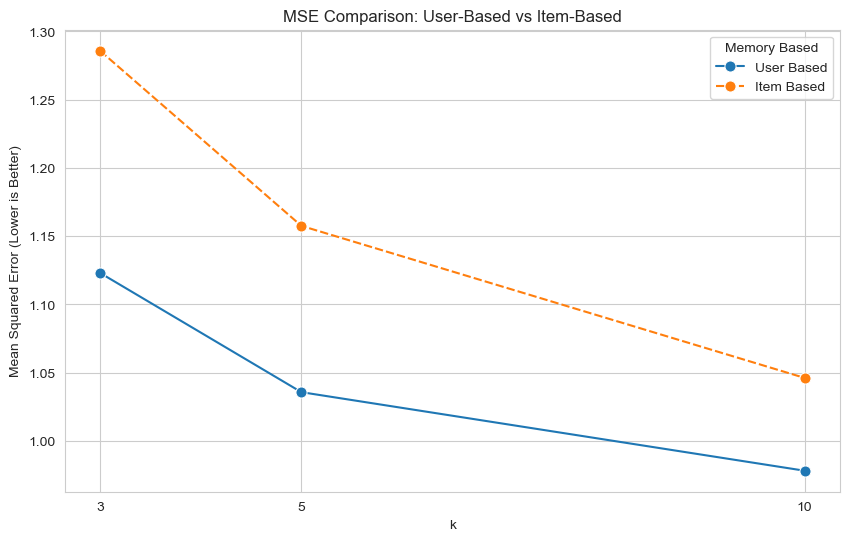

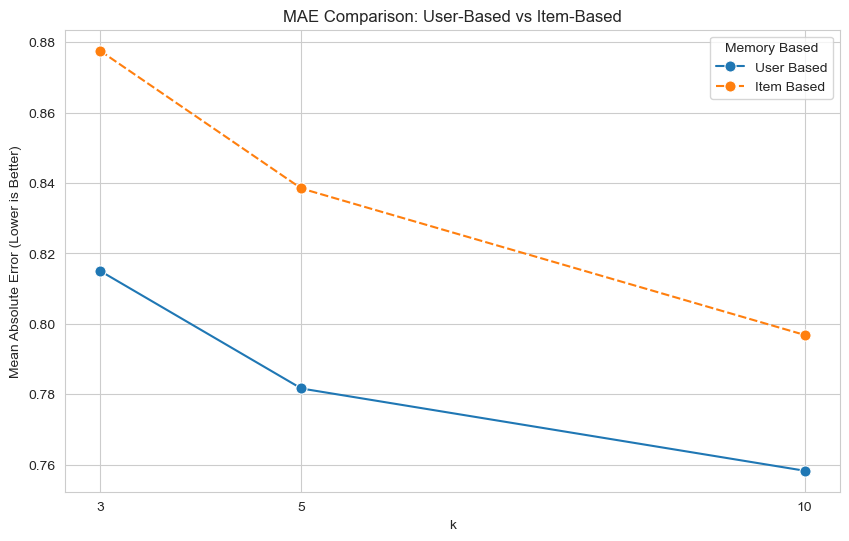


Final Results Summary:
  Memory Based   k       MSE       MAE
0   User Based   3  1.123067  0.815032
1   User Based   5  1.035690  0.781617
2   User Based  10  0.978120  0.758254
3   Item Based   3  1.285862  0.877575
4   Item Based   5  1.157551  0.838447
5   Item Based  10  1.046120  0.796835


In [ ]:
# Create DataFrame for Plotting
results_df = pd.DataFrame(result)

# Plot MSE vs K
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='MSE', hue='Memory Based', marker='o', style='Memory Based', markersize=8)
plt.title('MSE Comparison: User-Based vs Item-Based')
plt.xticks(k_values)
plt.ylabel('Mean Squared Error (Lower is Better)')
plt.grid(True)
plt.show()

# 6. Plot MAE vs K
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='k', y='MAE', hue='Memory Based', marker='o', style='Memory Based', markersize=8)
plt.title('MAE Comparison: User-Based vs Item-Based')
plt.xticks(k_values)
plt.ylabel('Mean Absolute Error (Lower is Better)')
plt.grid(True)
plt.show()

# 7. Print Final Summary Table
print("\nFinal Results Summary:")
print(results_df)

Interpretation: 
Likely characteristics of our dataset:

- Many users with overlapping rating habits

- Items may be sparse (some movies rated rarely)

- Users cluster naturally (groups with similar tastes)

Collaborative Filtering – Model Based:

In [84]:

# Define the models to evaluate _ this time with n_factors 
models_nf = {
    'SVD': SVD(),
    'SVD++': SVDpp(),
    'NMF': NMF()
}

model_results_nf = []

print("Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...")

# Iterate through models and run 5-fold CV
for name, algo in models_nf.items():
    print(f"\n--- Evaluating {name} ---")
    cv_res = cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    avg_mse = cv_res['test_mse'].mean()
    avg_mae = cv_res['test_mae'].mean()
    
    model_results_nf.append({
        'Model': name,
        'MSE': avg_mse,
        'MAE': avg_mae
    })
    print(f"{name} -> MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

# Create a DataFrame for the final table
final_model_df_with_nf = pd.DataFrame(model_results_nf)

# 4. Highlight the best metrics programmatically
best_mse_val_nf = final_model_df_with_nf['MSE'].min()
best_mae_val_nf = final_model_df_with_nf['MAE'].min()

# 5. Display the Final Table
print("\n" + "="*40)
print("FINAL MODEL COMPARISON RESULTS")
print("="*40)
print(final_model_df_with_nf.to_string(index=False))
print("-" * 40)
print(f"Best MSE: {best_mse_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MSE'] == best_mse_val_nf, 'Model'].values[0]})")
print(f"Best MAE: {best_mae_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MAE'] == best_mae_val_nf, 'Model'].values[0]})")
print("="*40)

Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...

--- Evaluating SVD ---
SVD -> MSE: 0.7633, MAE: 0.6712

--- Evaluating SVD++ ---
SVD++ -> MSE: 0.7389, MAE: 0.6586

--- Evaluating NMF ---
NMF -> MSE: 0.8481, MAE: 0.7054

FINAL MODEL COMPARISON RESULTS
Model      MSE      MAE
  SVD 0.763328 0.671184
SVD++ 0.738924 0.658583
  NMF 0.848115 0.705426
----------------------------------------
Best MSE: 0.7389 (Model: SVD++)
Best MAE: 0.6586 (Model: SVD++)


In [85]:
# Define the models to evaluate _ this time with n_factors 
models_nf = {
    'SVD': SVD(n_factors=5, random_state=42),
    'SVD++': SVDpp(n_factors=5, random_state=42),
    'NMF': NMF(n_factors=5, biased=True, random_state=42)
}

model_results_nf = []

print("Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...")

# Iterate through models and run 5-fold CV
for name, algo in models_nf.items():
    print(f"\n--- Evaluating {name} ---")
    cv_res = cross_validate(algo, surprise_data, measures=['MSE', 'MAE'], cv=5, verbose=False)
    
    avg_mse = cv_res['test_mse'].mean()
    avg_mae = cv_res['test_mae'].mean()
    
    model_results_nf.append({
        'Model': name,
        'MSE': avg_mse,
        'MAE': avg_mae
    })
    print(f"{name} -> MSE: {avg_mse:.4f}, MAE: {avg_mae:.4f}")

# Create a DataFrame for the final table
final_model_df_with_nf = pd.DataFrame(model_results_nf)

# 4. Highlight the best metrics programmatically
best_mse_val_nf = final_model_df_with_nf['MSE'].min()
best_mae_val_nf = final_model_df_with_nf['MAE'].min()

# 5. Display the Final Table
print("\n" + "="*40)
print("FINAL MODEL COMPARISON RESULTS")
print("="*40)
print(final_model_df_with_nf.to_string(index=False))
print("-" * 40)
print(f"Best MSE: {best_mse_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MSE'] == best_mse_val_nf, 'Model'].values[0]})")
print(f"Best MAE: {best_mae_val_nf:.4f} (Model: {final_model_df_with_nf.loc[final_model_df_with_nf['MAE'] == best_mae_val_nf, 'Model'].values[0]})")
print("="*40)

Running Model-Based Cross-Validation, the dimention of the latent space was choosen to be 5 for all three algorithms...

--- Evaluating SVD ---
SVD -> MSE: 0.7538, MAE: 0.6674

--- Evaluating SVD++ ---
SVD++ -> MSE: 0.7414, MAE: 0.6605

--- Evaluating NMF ---
NMF -> MSE: 0.7624, MAE: 0.6687

FINAL MODEL COMPARISON RESULTS
Model      MSE      MAE
  SVD 0.753825 0.667402
SVD++ 0.741402 0.660494
  NMF 0.762366 0.668703
----------------------------------------
Best MSE: 0.7414 (Model: SVD++)
Best MAE: 0.6605 (Model: SVD++)
